## 1. Load the training set and validation set.

In [1]:
%matplotlib inline
from sklearn.externals.joblib import Memory 
from sklearn.datasets import load_svmlight_file 
import numpy as np

def load_data(add,n=None):
    data = load_svmlight_file(add,n)
    return data[0],data[1]

data_train = "C:\\Users\\Administrator\\Desktop\\机器学习\\lab2\\a9a.txt"
data_valid = "C:\\Users\\Administrator\\Desktop\\机器学习\\lab2\\a9a_t.txt"

x_train,y_train = load_data(data_train,123)
x_valid,y_valid = load_data(data_valid,123)

x_train = x_train.todense()
x_valid = x_valid.todense()
#Step1::Load the training set and validation set

## 2.Initalize SVM model parameters randomly.

In [2]:
w = 2*(np.random.random([x_train.shape[1],1]))-1
b = np.random.random()*2-1
#Step2:Initalize logistic regression model parameters randomly.

w_temp = w #Store the random w
b_temp = b #Store the random b

## 4.Select the loss function and calculate its derivation.

In [3]:
#Step3:Select the loss function and calculate its derivation.

\begin{align}
min_{w,b}\quad L(w,b)&=\frac{||w||^2}{2}+\frac{C}{n}\sum_{i=1}^n max(0,1-y_i (w^T x_i +b))\\
                     &=\frac{1}{n}\sum_{i=1}^nL_i(w,b)
\end{align}

\begin{align}
g_w(x_i)&=-y_ix_i \quad \quad 1-y_i(w^Tx_i+b)>=0 \\
&=0 \quad \qquad  1-y_i(w^Tx_i+b)<0 
\end{align}

\begin{align}
g_b(x_i)&=-y_i \qquad 1-y_i(w^Tx_i+b)>=0 \\
&=0 \quad \qquad 1-y_i(w^Tx_i+b)<0 
\end{align}

\begin{align}
\frac{\partial L_i(w,b）}{\partial w}&=w+Cg_w(x_i) \\
\frac{\partial L_i(w,b）}{\partial b}&=Cg_b(x_i)
\end{align}

## 5.Linear Classification and Stochastic Gradient Descent

0.7637737239727289


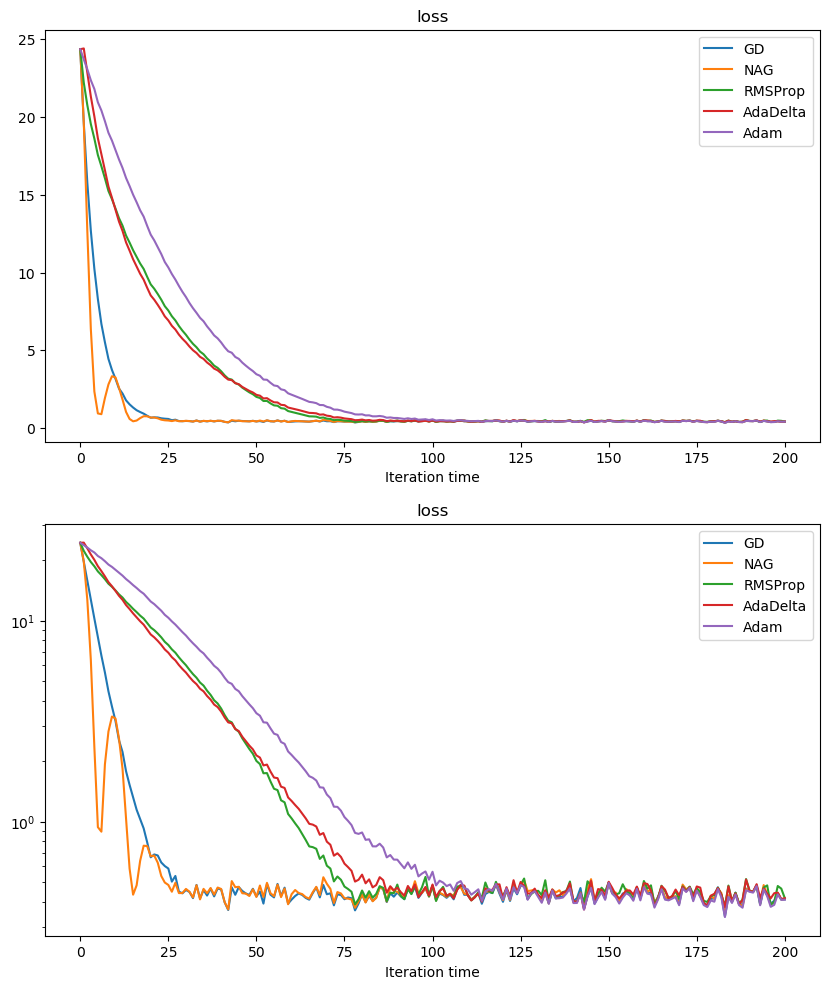

In [4]:
import matplotlib.pyplot as plt
from scipy import sparse

def getRandomBatch(num_batch,x,y):#Create random batch from data set
    x_batch = []
    y_batch = []
    for n in range(num_batch):
            n_r = np.random.randint(x.shape[0])
            x_batch.append(x[n_r])
            y_batch.append(y[n_r])

    x_batch = np.array(x_batch)
    y_batch = np.array(y_batch)
    y_batch.shape = (num_batch,1)
    return x_batch,y_batch

def get_loss(x,y,w,b): #Loss of data set
    Loss_sum = 0
    for n in range(0,x.shape[0]):
        Loss_sum = Loss_sum + max(0,(1 - y[n]*(x[n].dot(w)+b)))
            
    loss = ( 0.5*(w.T.dot(w)) + C/x.shape[0]*Loss_sum)[0,0]
    return loss

def get_gradient(x,y,w,b,C): #Calculate Gradient
    G_w_sum = np.zeros([x.shape[1],1])
    G_b_sum = 0
    for n in range(0,x.shape[0]):
        result = 1 - y[n]*(x[n].dot(w)+b)
        if(result>=0):
            G_w_sum = G_w_sum + w + C*(-np.mat(x[n]).T.dot(np.mat(y[n])))
            G_b_sum = G_b_sum + C*(-y[n])
        elif(result<0):
            G_w_sum = G_w_sum + w
            G_b_sum = G_b_sum
    return G_w_sum/x.shape[0],G_b_sum/x.shape[0]

def get_gradient_NAG(x,y,w,b,C,v,decay_rate): #Calculate Gradient
    G_w_sum = np.zeros([x.shape[1],1])
    G_b_sum = 0
    w = w + decay_rate*v[0:w.shape[0]]
    b = b + decay_rate*v[w.shape[0]]
    for n in range(0,x.shape[0]):
        result = 1 - y[n]*(x[n].dot(w)+b)
        if(result>=0):
            G_w_sum = G_w_sum + w + C*(-np.mat(x[n]).T.dot(np.mat(y[n])))
            G_b_sum = G_b_sum + C*(-y[n])
        elif(result<0):
            G_w_sum = G_w_sum + w
            G_b_sum = G_b_sum
    return G_w_sum/x.shape[0],G_b_sum/x.shape[0]

def update_w_GD(w,b,G_w,G_b,learn_rate): #Update w,b parameters

    w = w - learn_rate*G_w
    b = b - learn_rate*G_b
    return w,b

def update_w_NAG(w,b,v,G_w,G_b,learn_rate,decay_rate): #Update w,b parameters
    G = np.vstack((G_w,G_b))
    v = decay_rate*v - learn_rate*G
    w = w + v[0:w.shape[0]]
    b = b + v[w.shape[0]]
    return w,b,v

def update_w_RMSProp(w,b,r,G_w,G_b,learn_rate,decay_rate,mini_number): #Update w,b parameters
    G = np.vstack((G_w,G_b))
    r = decay_rate*r + (1-decay_rate)*G.T.dot(G)
    w = w - learn_rate*G_w/np.sqrt(mini_number + r)
    b = b - learn_rate*G_b/np.sqrt(mini_number + r)
    return w,b,r

def update_w_AdaDelta(w,b,E_g,E_w,G_w,G_b,learn_rate,decay_rate,mini_number): #Update w,b parameters
    G = np.vstack((G_w,G_b))
    E_g = decay_rate*E_g + (1-decay_rate)*G.T.dot(G)[0,0]
    w = w - np.sqrt(mini_number + E_w)/np.sqrt(mini_number + E_g)*G_w
    b = b - np.sqrt(mini_number + E_w)/np.sqrt(mini_number + E_g)*G_b
    E_w = decay_rate*E_w + (1-decay_rate)*( (learn_rate*G/np.sqrt(mini_number + E_g)).T.dot(learn_rate*G/np.sqrt(mini_number + E_g)) )[0,0]
    return w,b,E_g,E_w

def update_w_Adam(w,b,s,r,t,G_w,G_b,learn_rate,decay_rate1,decay_rate2,mini_number): #Update w,b parameters
    G = np.vstack((G_w,G_b))
    s = decay_rate1*s + (1-decay_rate1)*G
    r = decay_rate2*r + (1-decay_rate2)*G.T.dot(G)
    s_b = s/(1-np.power(decay_rate1,t))
    r_b = r/(1-np.power(decay_rate2,t))
    w = w - (learn_rate*s_b/(np.sqrt(r_b)+mini_number))[0:w.shape[0]]
    b = b - (learn_rate*s_b/(np.sqrt(r_b)+mini_number))[w.shape[0]]
    return w,b,s,r

def predict_result(x,w,b,threshold):# Predict y with w and data set
    y_predict = []
    for a in range(x.shape[0]):
        if((x[a].dot(w)+b)>=threshold):
            y_predict.append(1)
        else:
            y_predict.append(-1)
    return y_predict

def get_accuracy(y_predict,y_valid):#Calculate the accuracy
    accuracy = 0
    for a in range(y_valid.shape[0]):
        if(y_predict[a]==y_valid[a]):
            accuracy+=1
    return accuracy/y_valid.shape[0]

m_train = x_train.shape[0] #number of training example
m_valid = x_valid.shape[0] #number of validation example

loss_GD = [] #loss-axis
loss_NAG = [] #loss-axis
loss_RMSProp = [] #loss-axis
loss_AdaDelta = [] #loss-axis
loss_Adam = [] #loss-axis
x = [] #x-axis:the number of iterations

v_NAG = np.zeros([w.shape[0]+1,1]) 
decay_rate_NAG = 0.9

r_RMSProp = 0
decay_rate_RMSProp = 0.9
mini_number_RMSProp = 0.00000001

E_g_AdaDelta = 0
E_w_AdaDelta = 0
decay_rate_AdaDelta = 0.9
mini_number_AdaDelta = 0.00000001

s_Adam = 0
r_Adam = 0
decay_rate1_Adam = 0.9
decay_rate2_Adam = 0.999
mini_number_Adam = 0.00000001

C =0.9
learn_rate = 0.1 #Learning rate
threshold = 0
batch_num = 500
iteration = 200

w_GD = w_temp
b_GD = b_temp
w_NAG = w_temp
b_NAG = b_temp
w_RMSProp = w_temp
b_RMSProp = b_temp
w_AdaDelta = w_temp
b_AdaDelta = b_temp
w_Adam = w_temp
b_Adam = b_temp

x.append(0)
x_batch_valid,y_batch_valid = getRandomBatch(batch_num,x_valid,y_valid) 
#get the batch set from training set
loss_GD.append(get_loss(x_batch_valid,y_batch_valid,w_GD,b_GD))
loss_NAG.append(get_loss(x_batch_valid,y_batch_valid,w_NAG,b_NAG))
loss_RMSProp.append(get_loss(x_batch_valid,y_batch_valid,w_RMSProp,b_RMSProp))
loss_AdaDelta.append(get_loss(x_batch_valid,y_batch_valid,w_AdaDelta,b_AdaDelta))
loss_Adam.append(get_loss(x_batch_valid,y_batch_valid,w_Adam,b_Adam))
#Predict under validation set and get the loss

for n in range(iteration):#Step7:Repeate step 4 to 6 for several times
    x.append(n+1)
    
    x_batch,y_batch = getRandomBatch(batch_num,x_train,y_train) 
    #get the batch set from training set
    
    x_batch_valid,y_batch_valid = getRandomBatch(batch_num,x_valid,y_valid) 
    #get the batch set from training set
    
    G_w_GD,G_b_GD = get_gradient(x_batch,y_batch,w_GD,b_GD,C)
    G_w_NAG,G_b_NAG = get_gradient_NAG(x_batch,y_batch,w_NAG,b_NAG,C,v_NAG,decay_rate_NAG)
    G_w_RMSProp,G_b_RMSProp = get_gradient(x_batch,y_batch,w_RMSProp,b_RMSProp,C)
    G_w_AdaDelta,G_b_AdaDelta = get_gradient(x_batch,y_batch,w_AdaDelta,b_AdaDelta,C)
    G_w_Adam,G_b_Adam = get_gradient(x_batch,y_batch,w_Adam,b_Adam,C)
    #Step4:Calculate gradient G toward loss function from partial samples

    w_GD,b_GD = update_w_GD(w_GD,b_GD,G_w_GD,G_b_GD,learn_rate)
    w_NAG,b_NAG,v_NAG = update_w_NAG(w_NAG,b_NAG,v_NAG,G_w_NAG,G_b_NAG,learn_rate,decay_rate_NAG)
    w_RMSProp,b_RMSProp,r_RMSProp = update_w_RMSProp(w_RMSProp,b_RMSProp,r_RMSProp,G_w_RMSProp,G_b_RMSProp,learn_rate,decay_rate_RMSProp,mini_number_RMSProp)
    w_AdaDelta,b_AdaDelta,E_g_AdaDelta,E_w_AdaDelta = update_w_AdaDelta(w_AdaDelta,b_AdaDelta,E_g_AdaDelta,E_w_AdaDelta,G_w_AdaDelta,G_b_AdaDelta,learn_rate,decay_rate_AdaDelta,mini_number_AdaDelta)
    w_Adam,b_Adam,s_Adam,r_Adam = update_w_Adam(w_Adam,b_Adam,s_Adam,r_Adam,n+1,G_w_Adam,G_b_Adam,learn_rate,decay_rate1_Adam,decay_rate2_Adam,mini_number_Adam)
    #Step5:Update model parameters using different optimized method.
    
    loss_GD.append(get_loss(x_batch_valid,y_batch_valid,w_GD,b_GD))
    loss_NAG.append(get_loss(x_batch_valid,y_batch_valid,w_NAG,b_NAG))
    loss_RMSProp.append(get_loss(x_batch_valid,y_batch_valid,w_RMSProp,b_RMSProp))
    loss_AdaDelta.append(get_loss(x_batch_valid,y_batch_valid,w_AdaDelta,b_AdaDelta))
    loss_Adam.append(get_loss(x_batch_valid,y_batch_valid,w_Adam,b_Adam))
    #Step6:Predict under validation set and get the loss
    
plt.figure(figsize=(10,12),dpi=100)
f1 = plt.subplot(211)
f1.set_xlabel("Iteration time")
f1.set_title("loss")
plt.plot(x, loss_GD,label = 'GD')
plt.plot(x, loss_NAG,label = 'NAG')
plt.plot(x, loss_RMSProp,label = 'RMSProp')
plt.plot(x, loss_AdaDelta,label = 'AdaDelta')
plt.plot(x, loss_Adam,label = 'Adam')
plt.legend()
#Step8:drawing graph of loss with the number of iterations.

f2 = plt.subplot(212)
f2.set_xlabel("Iteration time")
f2.set_title("loss")
plt.yscale('log')
plt.plot(x, loss_GD,label = 'GD')
plt.plot(x, loss_NAG,label = 'NAG')
plt.plot(x, loss_RMSProp,label = 'RMSProp')
plt.plot(x, loss_AdaDelta,label = 'AdaDelta')
plt.plot(x, loss_Adam,label = 'Adam')
plt.legend()

y_predict = predict_result(x_valid,w_NAG,b_NAG,threshold) # Predict y with w and data set
print(get_accuracy(y_predict,y_valid)) #Calculate the accuracy